 <center><h2> PREDICTING MOVIE RATINGS FROM AUDIENCE BEHAVIOURS ON MOVIE TRAILERS

### <center><h2> Research Model New - Rottantomatoes

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from termcolor import colored
from joblib import dump
import plotly.graph_objects as go
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from os import path
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from statistics import mean, stdev 

 <h4>File Path Setup

In [17]:
inputFilePath = 'Model_Input_Data/'

resultFilePath = 'User_Ratings/Results/'
modelFilePath = 'User_Ratings/Model_File/'
graphFilePath = 'User_Ratings/Research_Graphs/'

textFile = open(resultFilePath+'New Testing Accuracy.txt.txt', "w")
textFile.write("PREDICTING MOVIE RATINGS FROM AUDIENCE BEHAVIOURS ON MOVIE TRAILERS\n\n\n")

df_Input =  pd.DataFrame()

<h3>Feature Scale Function

In [18]:
def featureScale():
    
    global df_Input
    
    scaler = MinMaxScaler()
    
    columnsList = df_Input.columns
    
    df_Input = pd.DataFrame(scaler.fit_transform(df_Input), columns=columnsList)

<h3>Feature Selection Function

In [19]:
def featureSelection(windowSize):
    
    global df_Input
    
    correlation = df_Input.corr()
    cor_target = abs(correlation['UserRating'])
    cor_target = cor_target.sort_values(ascending=False)
    #Selecting highly correlated features
    irrelevant_features = cor_target[cor_target<0.075].index
    #irrelevant_features = cor_target[50:].index
    df_Input = df_Input.drop(irrelevant_features, axis=1)
    
    correlation = df_Input.corr()
    plt.figure()
    sns.heatmap(correlation, annot=True, cmap=plt.cm.Reds)
    plt.savefig(graphFilePath + 'Correlation Matrix' + windowSize + '.png',dpi=1200)
    plt.show()

<h3>Principal component analysis Function

In [20]:
def pcafunc():
    
    global df_Input
    
    y = df_Input['UserRating']
    X = df_Input.drop(['UserRating'], 1)
        
    pca = PCA(n_components=42)
    pca.fit(X,y)
    PCA_features = pca.transform(X)
    
    df_Input = pd.DataFrame(data = PCA_features)
    
    df_Input['UserRating'] = y

<h3> Input Data Function

In [21]:
def inputSetup(windowSize):
    
    global df_Input
    global df_ModelInput
    
    inputFile = inputFilePath+'Model_Input_Data_'+windowSize+'.csv'
    
    df_Input = pd.read_csv(inputFile)
    df_Input = df_Input.drop(['Rating','Genre'], 1)
    y = df_Input['UserRating']
    
    featureScale()
    featureSelection(windowSize)
    #pcafunc()
    
    X = df_Input.drop(['UserRating'], 1)
    
    return X,y    

<h4>This method reads the csv file and split into 66-33 ration for training and testing

<h3> Input Data Split Function

In [22]:
def inputSplit(windowSize):
    
    X,y = inputSetup(windowSize)
    
    train_features, test_features, train_labels, test_labels = train_test_split(X, y,test_size=0.33 ,  random_state=5)
    
    return  train_features, test_features, train_labels, test_labels

 <h3> Plot Graph files Function

In [23]:
def plotgraph(test_labels,predict_labels,modelResults):
    
    fig = go.Figure(data=go.Scatter(y=test_labels, name='Actual rating'))
    fig.add_trace(go.Scatter(y=predict_labels, name='Predicting rating'))
    
    fig.update_layout(title=modelResults['Classifier']+' RMSE: {:.2f}'.format(modelResults['RMSE']))
    
    #fig.write_html( graphFilePath + modelResults['Classifier'] +'.html', auto_open=False)
    fig.write_image(graphFilePath + modelResults['Classifier'] +'.png')

 <h4>This method plots the actual ratings vs predicted ratings

 <h3> Results to TextFile Function

In [24]:
def resultsToText(modelResults):
    
    textFile.writelines(modelResults['Classifier'] 
                        + "\t\t : {}".format(modelResults['MAE']) 
                        + "\t\t : {}".format(modelResults['MSE'])
                        + "\t\t : {}".format(modelResults['RMSE']) 
                        + "\n\n")

<h4>This method store the evaluation results in a text file

<h3>Results to CSV Function

In [25]:
def resultsToCSV(modelResults):
    
    resultsToText(modelResults)
    
    df_results = pd.DataFrame(columns = ['Classifier','MAE', 'MSE' , 'RMSE']) 
    
    df_results = df_results.append(modelResults, ignore_index=True)
    
    return df_results

<h4>This method store the evaluation results in a csv file

 <h2> Model Train, Test and Evaluation

In [26]:
def classifierTest(modelInput):
    
    model = modelInput['classifier']
    model.fit(modelInput['train_features'], modelInput['train_labels'])
    predict_labels = model.predict(modelInput['test_features'])
    
    MAE = mean_absolute_error(modelInput['test_labels'], predict_labels)
    MSE = mean_squared_error(modelInput['test_labels'], predict_labels)
    RMSE = math.sqrt(MSE)
    
    modelResults = {'Classifier':modelInput['classifierName'],'MAE': MAE,'MSE': MSE,'RMSE': RMSE}
    
    plotgraph(modelInput['test_labels'],predict_labels,modelResults)

    dump(model, modelFilePath + modelInput['classifierName'] + '_model.joblib')
    
    return resultsToCSV(modelResults)

<h4>This method train test and evaluate the testing models and store the result in a csv file

<h2> Classifier model Testing

In [27]:
df_Output = pd.DataFrame(columns=['Classifier','MAE', 'MSE' , 'RMSE'])

In [28]:
def classifierListTest(windowSize,classifierTitleList,classifiersList):
    
    global df_Output
    
    train_features, test_features, train_labels, test_labels = inputSplit(windowSize) #Splited data
    
    modelInput = {
                    'train_features':train_features,'test_features':test_features,
                    'train_labels':train_labels,'test_labels':test_labels
                 }
    
    for index in range(len(classifiersList)): 
        
        classifier = classifiersList[index]
        classifierTitle = classifierTitleList[index]        
        
        modelInput.update({'classifier':classifier,'classifierName':classifierTitle +"_"+windowSize})
        
        df_Output = df_Output.append(classifierTest(modelInput), ignore_index=True)
        
    return df_Output

In [29]:
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LinearRegression


classifierTitleList = [ 
                    'MLPClassifier-adam', 'KNeighborsClassifier', 'SVC(gamma=2, C=1)','LinearDiscriminant', 'LinearRegression'
                ]

# Define the model
classifiersList = [
               MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1),
               KNeighborsClassifier(),
               SVC(gamma=2, C=1),
               LinearDiscriminantAnalysis(),
               LinearRegression()
            ]

### <h1>Model Testing

In [30]:
def windowTest(classifierTitleList,classifiersList):
    
    windowSize = ['4','5','10']

    for i in range(len(windowSize)):
        classifierListTest(windowSize[i],classifierTitleList,classifiersList)

C:\Users\chath\AppData\Local\Temp\ipykernel_9780\1161048317.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_Input = df_Input.drop(['Rating','Genre'], 1)


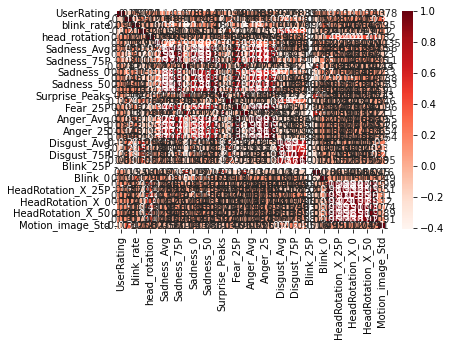

C:\Users\chath\AppData\Local\Temp\ipykernel_9780\1161048317.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = df_Input.drop(['UserRating'], 1)
C:\Users\chath\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\chath\AppData\Local\Temp\ipykernel_9780\3323749433.py:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\chath\AppData\Local\Temp\ipykernel_9780\3307006908.py:19: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\chath\AppData\Local\Temp\ipykernel_9780\3323749433.py:7: FutureWarning:

The frame.append method is deprecated and wil

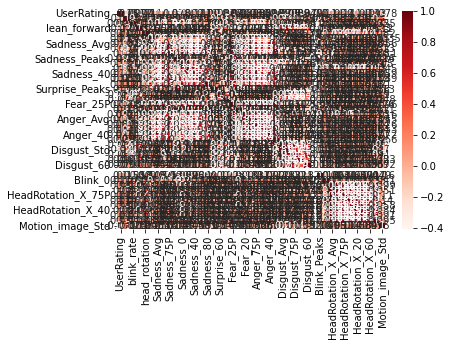

C:\Users\chath\AppData\Local\Temp\ipykernel_9780\1161048317.py:16: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

C:\Users\chath\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

C:\Users\chath\AppData\Local\Temp\ipykernel_9780\3323749433.py:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\chath\AppData\Local\Temp\ipykernel_9780\3307006908.py:19: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\chath\AppData\Local\Temp\ipykernel_9780\3323749433.py:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pa

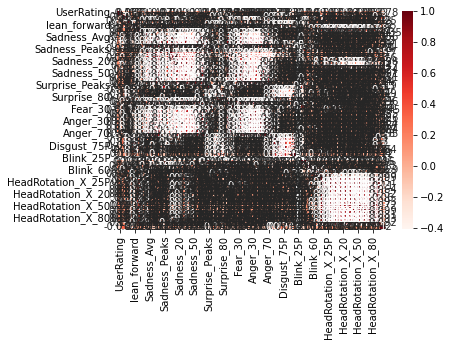

C:\Users\chath\AppData\Local\Temp\ipykernel_9780\1161048317.py:16: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

C:\Users\chath\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

C:\Users\chath\AppData\Local\Temp\ipykernel_9780\3323749433.py:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\chath\AppData\Local\Temp\ipykernel_9780\3307006908.py:19: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\chath\AppData\Local\Temp\ipykernel_9780\3323749433.py:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pa

In [31]:
windowTest(classifierTitleList,classifiersList)

In [32]:
df_Output = df_Output.sort_values(by=['RMSE'],ascending=True).round(decimals=3)

<h4>RandomForestClassifier is showing lowest RMSE for 10 windows

<h3> RandomForestClassifier has lowers RMSE for each window method

### <h1>Best Model Optimizing

In [18]:
from sklearn.model_selection import GridSearchCV
import time

# Create the random grid
parameters = {'fit_intercept': [True,False],
              'normalize': [True,False],
              'copy_X' : [True,False],
              'n_jobs' : [None,1,2,3]
             }

In [19]:
def GridSearchOptimizing(windowSize):
    
    X,y = inputSetup(windowSize)
    
    #Use GridSearch
    clf = GridSearchCV(LinearRegression(), parameters, cv=3, n_jobs=-1, verbose=1)

    t0 = time.time()
    #Fit the model
    best_model = clf.fit(X,y)
    t1 = time.time()

    optimizingTime = t1-t0


    best_fit_intercept = best_model.best_estimator_.get_params()['fit_intercept']
    best_normalize = best_model.best_estimator_.get_params()['normalize']
    best_copy_X = best_model.best_estimator_.get_params()['copy_X']
    best_n_jobs = best_model.best_estimator_.get_params()['n_jobs']


    print('optimizing Time\t\t:\t', optimizingTime," Sec")
    
    print('Best fit_intercept\t:\t', best_fit_intercept)
    print('Best normalize\t\t:\t', best_normalize)
    print('Best copy_X\t\t:\t', best_copy_X)
    print('Best n_jobs\t\t:\t', best_n_jobs)
    
    optimized_model = LinearRegression(fit_intercept= best_fit_intercept,
                                         normalize = best_normalize,
                                         copy_X = best_copy_X,
                                         n_jobs = best_n_jobs,
                                        )
    return optimized_model

In [39]:
def OptimizedModelTest():
    global classifierTitleList
    global classifiersList
    optimized_model = GridSearchOptimizing('4')
    classifiersTemp = [optimized_model]
    classifierTitleTemp = ['Optimized_model']
    windowTest(classifierTitleTemp,classifiersTemp)
    classifierTitleList = classifierTitleList + classifierTitleTemp
    classifiersList = classifiersList + classifiersTemp

In [41]:
# OptimizedModelTest()

In [42]:
df_Output = df_Output.sort_values(by=['RMSE'],ascending=True).round(decimals=3)

In [43]:
df_Output.to_csv(resultFilePath+'Results.csv')

In [44]:
textFile.close()

### <h1> Model Validation

In [45]:
df_VP = pd.DataFrame(columns=['Classifier','RMSE_Avg','RMSE_Max','RMSE_Min','StD','Test_RMSE'])
df_Output2 = df_Output.set_index('Classifier')['RMSE']

In [46]:
def classifierValidation(classifierTitle,model,X,y):    
    
    global df_VP    
    
    kf = KFold(n_splits=15, random_state=None, shuffle=True)
    
    X =  X.values
    
    scaler = MinMaxScaler()
    #X = scaler.fit_transform(X)
    
    kf.get_n_splits(X)
    ValidationScore = []
    

    for train_index, test_index in kf.split(X, y): 
        x_train_fold, x_test_fold = X[train_index], X[test_index] 
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        
        model.fit(x_train_fold, y_train_fold)
        predict_labels = model.predict(x_test_fold)
        
        MSE = mean_squared_error(y_test_fold, predict_labels)
        RMSEScore = math.sqrt(MSE)
        ValidationScore.append(RMSEScore)
        
    modelResults = {'Classifier':classifierTitle,
                    'RMSE_Avg': mean(ValidationScore),
                    'RMSE_Max': max(ValidationScore),
                    'RMSE_Min': min(ValidationScore),
                    'StD':stdev(ValidationScore),
                    'Test_RMSE': df_Output2.at[classifierTitle],
                   }
    df_VP = df_VP.append(modelResults, ignore_index=True)

In [47]:
def classifierListValidation(windowSize): 
    
    X,y = inputSetup(windowSize)
    
    global classifiers
    
    for index in range(len(classifiersList)): 
        
        model = classifiersList[index]
        classifierName = classifierTitleList[index] +"_"+ windowSize
        
        classifierValidation(classifierName,model,X,y)

In [48]:
def windowValidation():
    
    windowSize = ['4','5','10']

    for i in range(len(windowSize)):
        
        classifierListValidation(windowSize[i])

C:\Users\chath\AppData\Local\Temp\ipykernel_9780\1161048317.py:9: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



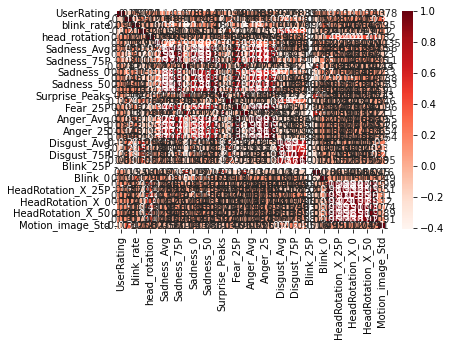

C:\Users\chath\AppData\Local\Temp\ipykernel_9780\1161048317.py:16: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

C:\Users\chath\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

C:\Users\chath\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

C:\Users\chath\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

C:\Users\chath\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning:

Stochastic Optimizer: Maximum 

In [ ]:
windowValidation()

### Validation Results

In [ ]:
df_VP = df_VP.sort_values(by=['RMSE_Avg'],ascending=True).round(decimals=3)

In [ ]:
df_VP

In [36]:
df_VP.to_csv(resultFilePath+'ResearchValidationResults.csv')

NameError: name 'df_VP' is not defined